In [10]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.BRUTAL_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date

In [11]:
n_seas = 2
iters = 100

In [12]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=20, lon=80, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=20, lon=80, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=20, lon=80, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=20, lon=80, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

In [13]:
datasets_tab = [dataset.to_dataframe() for dataset in datasets]

datasets_tab = [dataset.dropna() for dataset in datasets_tab]
datasets_tab = pd.concat(datasets_tab, axis=1)

datasets_tab = datasets_tab.drop(columns=['lon','lat','spatial_ref'])
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [14]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,295.927063,294.983826,294.420837,294.167358,299.325226,294.647644,293.918121,294.061096,295.376556,294.926697,...,0.244518,-1.727165,-1.555467,-0.142268,-1.138127,-0.309030,-2.623585,-1.944055,-0.902206,-2.439289
2,295.840546,295.199738,294.424622,294.020966,299.314453,294.644714,293.994293,294.156891,295.269684,294.628632,...,0.565744,-1.898481,-1.795564,-0.161588,-1.096165,0.042204,-2.663824,-1.626914,-0.701875,-2.355678
3,295.834167,295.429810,294.447540,293.884094,299.244476,294.544403,294.123230,294.214264,295.322693,294.365112,...,0.703103,-1.854858,-2.133983,-0.197010,-1.118048,0.530577,-2.590106,-1.608586,-0.588052,-2.328299
4,295.996521,295.731537,294.554688,293.819641,299.181824,294.525970,294.258392,294.350647,295.354980,293.954437,...,0.708095,-1.979034,-2.412103,-0.220490,-1.201267,0.712777,-2.569694,-1.577574,-0.578956,-2.340635
5,296.396851,296.032715,294.653900,293.863617,299.191742,294.473724,294.284698,294.428314,295.405640,293.563507,...,0.750707,-1.968890,-2.544425,-0.244416,-1.290177,0.356934,-2.589711,-1.454663,-0.679592,-2.461563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,295.021027,294.119843,293.987701,298.807129,295.234100,294.169250,293.547150,295.578705,295.220093,294.531097,...,-1.725683,-0.427331,-1.465740,-1.474821,-0.156374,-2.184415,-1.715156,-2.097935,-2.694688,-1.922331
363,294.992249,294.160950,294.058105,298.929779,295.121643,294.000336,293.700775,295.484375,295.121429,294.691711,...,-1.773564,-0.534264,-1.126816,-1.396205,-0.115783,-2.318379,-2.051592,-2.074748,-2.635578,-1.674824
364,294.908386,294.287964,294.091370,299.033142,294.941315,293.828430,293.849121,295.356079,295.028259,294.775604,...,-1.712108,-0.753580,-0.757307,-1.147677,-0.332233,-2.375957,-2.254198,-2.022546,-2.488880,-1.260049


In [15]:
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,-1.513954,-1.369081,-1.490333,-1.648248,-0.450333,-1.468021,-1.397972,-1.772378,-1.525183,-1.322568,...,0.037582,-1.261101,-1.017695,-0.192562,-0.790109,-0.419768,-2.106272,-1.050431,-0.566341,-1.336105
2,-1.535586,-1.319108,-1.489339,-1.681281,-0.452517,-1.468688,-1.382362,-1.749249,-1.551718,-1.387516,...,0.288071,-1.351989,-1.151414,-0.203416,-0.765556,-0.160200,-2.132991,-0.904601,-0.444788,-1.296288
3,-1.537180,-1.265858,-1.483318,-1.712165,-0.466705,-1.491552,-1.355937,-1.735398,-1.538557,-1.444936,...,0.395183,-1.328846,-1.339893,-0.223315,-0.778360,0.200716,-2.084042,-0.896173,-0.375724,-1.283249
4,-1.496588,-1.196023,-1.455169,-1.726709,-0.479407,-1.495754,-1.328237,-1.702470,-1.530540,-1.534422,...,0.399076,-1.394724,-1.494789,-0.236505,-0.827052,0.335366,-2.070489,-0.881913,-0.370205,-1.289124
5,-1.396495,-1.126315,-1.429105,-1.716786,-0.477396,-1.507662,-1.322845,-1.683718,-1.517962,-1.619604,...,0.432304,-1.389342,-1.568484,-0.249946,-0.879074,0.072391,-2.083780,-0.825395,-0.431267,-1.346712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,-1.740486,-1.569051,-1.604124,-0.601301,-1.279785,-1.577061,-1.474000,-1.405972,-1.564031,-1.408769,...,-1.498764,-0.571509,-0.967722,-0.941150,-0.215677,-1.805712,-1.503072,-1.121189,-1.653952,-1.089920
363,-1.747681,-1.559536,-1.585628,-0.573625,-1.302585,-1.615562,-1.442515,-1.428747,-1.588529,-1.373771,...,-1.536101,-0.628240,-0.778963,-0.896986,-0.191927,-1.904714,-1.726467,-1.110526,-1.618086,-0.972053
364,-1.768649,-1.530139,-1.576889,-0.550302,-1.339145,-1.654745,-1.412113,-1.459722,-1.611662,-1.355491,...,-1.488178,-0.744592,-0.573169,-0.757370,-0.318574,-1.947265,-1.860998,-1.086522,-1.529075,-0.774530


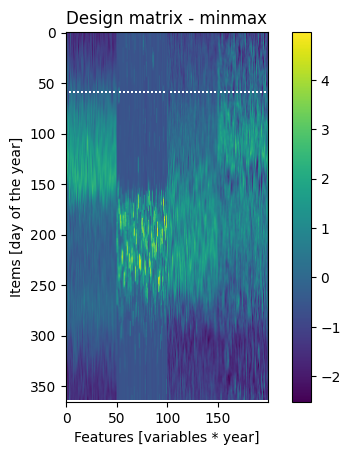

In [16]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [17]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [31]:

n_days = list(np.arange(0,365,10))

best, err, bp_list = single_fit_optimized(array_tot, n_seas, n_days, metric='crps')

666it [06:19,  1.75it/s]


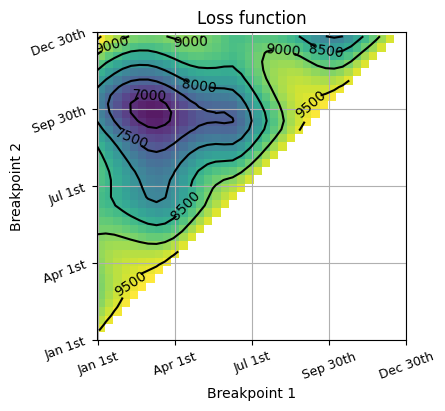

In [32]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

        

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

In [33]:
# generate random number between 0 and 365
list(np.sort(np.random.randint(0, 365, 2)))

[82, 346]

Text(0, 0.5, 'WCSS')

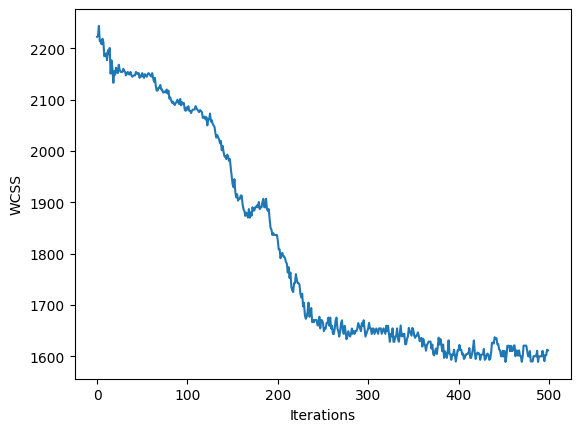

In [34]:
clustering_params = {
        'n_iter': 500,
        'n_seas': 2,
        'learning_rate': 20,
        'scheduling_factor' : 1.1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(0, 365, 2))),
        'metric': 'euclidean',
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

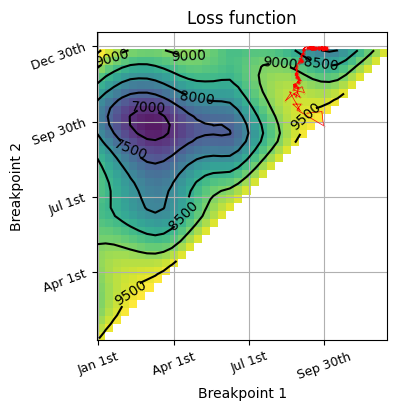

In [35]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)

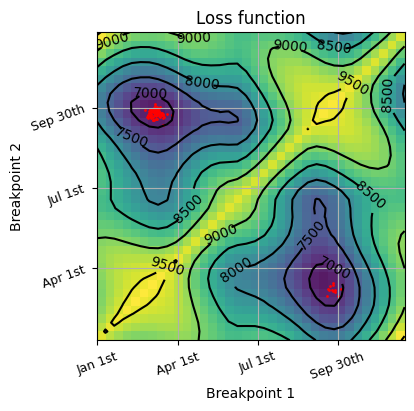

In [36]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

Z = np.where(np.isnan(Z), Z.T, Z)

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

for j in range(100):
    
    clustering_params = {
        'n_iter': 200,
        'n_seas': 2,
        'learning_rate': 5,
        'scheduling_factor' : 1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(30, 335, 2))),
        'metric': 'euclidean',
    }
    model = Radially_Constrained_Cluster(array_tot, **clustering_params)

    model.fit()
    #plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.05, markersize=0.05)
    plt.scatter(model.breakpoint_history[-1,0],model.breakpoint_history[-1,1], color='red', s=1)

In [37]:
import CRPS.CRPS as pscore


# a = []

# for j in np.arange(0,20):
#     crps,fcrps,acrps = pscore(array_tot.flatten(),j).compute()
#     a.append(crps)

#plt.plot(a)

# I want a function that computes the crps for each values insidea a vector.

# I want to compute the crps for each value of the vector and then plot the crps for each value of the vector.


import numpy as np



